# Preparation

In [1]:
import torch
torch.__version__

ModuleNotFoundError: No module named 'torch'

In [2]:
import os
import pandas as pd
import numpy as np
import random
from torch import nn

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from model import *
from dataset import *
from train import *

ModuleNotFoundError: No module named 'torch'

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
BATCH_SIZE = 256
NUMEPOCHS = 50

In [ ]:
# import pandas as pd
# df = pd.read_csv("Data/ml-1m.train.rating",sep='\t', header=None, names=['uid', 'mid', 'rating', 'timestamp'], engine='python')
# df

In [ ]:
# df2 = pd.read_csv("Data/ml-1m.test.negative",sep = "\t",header=None)
# df2

# Trian and Test

### Compare the three methods 

In [ ]:
# model_config_mf = {
#     "model_mark": "gmf(mf_dim=8)",
#     'embedding_dim_mf': 8,
#     # "mlp_layers(X)" : 0,
#     # 'mlp_layers': [ 32, 16, 8],
#     'model_type': 'GMF'     #　MLP, NeuMF
# }

# model_config_mlp = {
#     "model_mark": "mlp(mlp_layer=3)",
#     "mlp_layers(X)" : 3,
#     'mlp_layers': [64, 32, 16, 8],
#     'model_type': 'MLP'     #　MLP, NeuMF
# }

# model_config_neumf = {
#     "model_mark": "neumf(mf_dim=8,mlp_layer=3)",
#     'embedding_dim_mf': 8,
#     "mlp_layers(X)" : 3,
#     'mlp_layers': [64, 32, 16, 8],
#     'model_type': 'NeuMF'     #　MLP, NeuMF
# }

# model_train(model_config_mf, seed = 42, num_of_negatives=4, num_of_epochs = 40)


In [ ]:
# model_train(model_config_mlp, seed = 42, num_of_negatives=4, num_of_epochs=40)


In [ ]:
# model_train(model_config_neumf, seed = 42, num_of_negatives=4, num_of_epochs=40)


for movielens

HR, NDCG

-   GMF(Factor-8, X-0): 0.6339, 0.3621
-   MLP(Factor-8, X-3): 0.6109, 0.3434
-   NeuMF(Factor-8, X-3): 0.6474, 0.3731

## Reproduce the ablation study --- MLP with different layers

 K: 8
 
 layers (X): 0, 1, 2, 3, 4

In [ ]:
model_config_mlp0 = {
    "model_mark": "mlp(mlp_layer=0)",
    "mlp_layers(X)" : 0,
    'mlp_layers': [8],
    'model_type': 'MLP'     #　MLP, NeuMF
}

model_config_mlp1 = {
    "model_mark": "mlp(mlp_layer=1)",
    "mlp_layers(X)" : 1,
    'mlp_layers': [16,8],
    'model_type': 'MLP'     #　MLP, NeuMF
}

#! [8][:-1],[8][1:]    # ([], [])
#! [8,16][:-1],[8,16][1:]  # ([8], [16])

model_config_mlp2 = {
    "model_mark": "mlp(mlp_layer=2)",
    "mlp_layers(X)" : 2,
    'mlp_layers': [32,16, 8],
    'model_type': 'MLP'     #　MLP, NeuMF
}

model_config_mlp3 = {
    "model_mark": "mlp(mlp_layer=3)",
    "mlp_layers(X)" : 3,
    'mlp_layers': [64,32, 16, 8],
    'model_type': 'MLP'     #　MLP, NeuMF
}

model_config_mlp4 = {
    "model_mark": "mlp(mlp_layer=4)",
    "mlp_layers(X)" : 4,
    'mlp_layers': [128,64, 32, 16, 8],
    'model_type': 'MLP'     #　MLP, NeuMF
}

# model_train(model_config_mlp0, seed = 42, num_of_negatives=4, num_of_epochs=40)


In [ ]:
# model_train(model_config_mlp1, seed = 42, num_of_negatives=4, num_of_epochs=40)


In [ ]:
# model_train(model_config_mlp2, seed = 42, num_of_negatives=4, num_of_epochs=40)


In [ ]:
# model_train(model_config_mlp3, seed = 42, num_of_negatives=4, num_of_epochs=40)


In [ ]:
# model_train(model_config_mlp4, seed = 42, num_of_negatives=4, num_of_epochs=40)


HR, NDCG

-   MLP0: 0.4538, 0.2525
-   MLP1: 0.5197, 0.2901
-   MLP2: 0.5745, 0.3196
-   MLP3: 0.6109, 0.3434
-   MLP4: 0.6278, 0.3554

# Plot

### 3 models

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

In [4]:
df1 = pd.DataFrame({
    "Name":["GMF","MLP","NeuMF"],
    "HR@10":[0.6339,0.6109,0.6474],
    "NDCG@10": [0.3621, 0.3434, 0.3731]
    }
)
df1 = df1.loc[:,["HR@10","NDCG@10"]].stack().reset_index().rename(columns={"level_1":"Metric",0:"Value","level_0":"Model"})
df1["Model"] = df1["Model"].map({0:"GMF",1:"MLP",2:"NeuMF"})
df1

,Model,Metric,Value
0,GMF,HR@10,0.6339
1,GMF,NDCG@10,0.3621
2,MLP,HR@10,0.6109
3,MLP,NDCG@10,0.3434
4,NeuMF,HR@10,0.6474
5,NeuMF,NDCG@10,0.3731


In [5]:
color_list = ["#10323a","#569a4d"]
custom_palette = sns.color_palette(color_list)

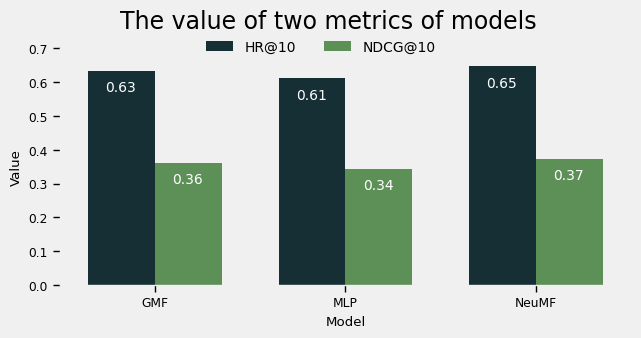

In [7]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="paper"):
    fig = plt.figure(figsize=(6.5, 3.5))
    bar = sns.barplot(data = df1,x = 'Model', y = 'Value', hue = 'Metric',width = 0.7,palette = custom_palette)
    plt.legend(bbox_to_anchor=(0.5,0.9),loc = "upper center",ncol = 2,fontsize = 10, frameon = False,bbox_transform=fig.transFigure )
    plt.ylim(0,0.7)
    plt.title("The value of two metrics of models",fontsize = 17,x = 0.47,y = 1.05)
        # 在柱形图上标注数值
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (-0.5, -12), 
                     textcoords = 'offset points',
                     fontsize = 10,
                     color = "white")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    fig.savefig("report/3models.svg")

### mlp layers

In [8]:
df2 = pd.DataFrame({
    "Model": ["MLP0","MLP1","MLP2","MLP3","MLP4"],
    "HR@10":[0.4538,0.5197,0.5745,0.6109,0.6278],
    "NDCG@10":[0.2525,0.2901,0.3196,0.3434,0.3554]
})

df2 = df2.loc[:,["HR@10","NDCG@10"]].stack().reset_index().rename(columns={"level_1":"Metric",0:"Value","level_0":"Model"})
df2["Model"] = df2["Model"].map({0:"MLP0",1:"MLP1",2:"MLP2", 3:"MLP3",4:"MLP4"})
df2

,Model,Metric,Value
0,MLP0,HR@10,0.4538
1,MLP0,NDCG@10,0.2525
2,MLP1,HR@10,0.5197
3,MLP1,NDCG@10,0.2901
4,MLP2,HR@10,0.5745
5,MLP2,NDCG@10,0.3196
6,MLP3,HR@10,0.6109
7,MLP3,NDCG@10,0.3434
8,MLP4,HR@10,0.6278
9,MLP4,NDCG@10,0.3554


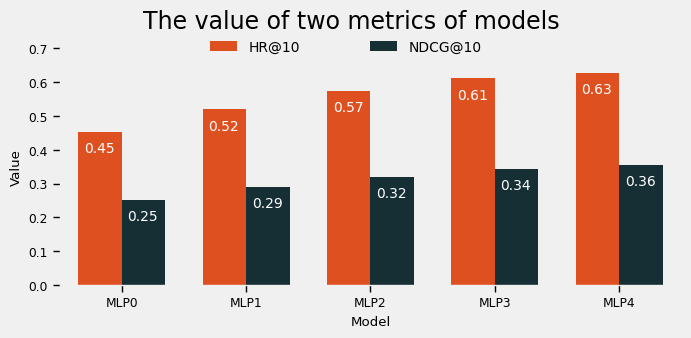

In [9]:
color_list2 = ["#ff4000","#10323a"]
custom_palette2 = sns.color_palette(color_list2)

with plt.style.context("fivethirtyeight"), sns.plotting_context(context="paper"):
    fig = plt.figure(figsize=(7, 3.5))
    bar = sns.barplot(data = df2,x = 'Model', y = 'Value', hue = 'Metric',width = 0.7,palette=custom_palette2)
    plt.legend(bbox_to_anchor=(0.5,0.9),loc = "upper center",ncol = 2,fontsize = 10, frameon = False,bbox_transform=fig.transFigure , columnspacing = 5)
    plt.ylim(0,0.7)
    plt.title("The value of two metrics of models",fontsize = 17,x = 0.47,y = 1.05)
        # 在柱形图上标注数值
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (-0.5, -12), 
                     textcoords = 'offset points',
                     fontsize = 10,
                     color = "white")
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    fig.savefig("report/MLP.svg")